This notebook is used for exploratory data analysis.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [3]:
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARMA

In [5]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

In [6]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM

In [7]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


Load data now:

In [8]:
file_name = "./data/network-traffic-volume-2019-07-01.csv"

In [9]:
df = pd.read_csv(file_name, sep=';')

In [10]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max
0,159138,1563192000,60,170651112,222446310,245355432
1,159138,1563188400,60,92258968,156333926,245517360
2,159138,1563184800,60,29854256,73581269,121096792
3,159138,1563181200,60,333720,12801917,43525128
4,159138,1563177600,60,183976,1146488,11797152


In [11]:
df.shape

(4319, 6)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4319 entries, 0 to 4318
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   itemid     4319 non-null   int64
 1   clock      4319 non-null   int64
 2   num        4319 non-null   int64
 3   value_min  4319 non-null   int64
 4   value_avg  4319 non-null   int64
 5   value_max  4319 non-null   int64
dtypes: int64(6)
memory usage: 202.6 KB


There is no missing data. All data are integers, including the clock timestamp. Now we transform the clock format:

In [13]:
start = datetime(1970, 1, 1)  # Unix epoch start time
df['datetime'] = df.clock.apply(lambda x: start + timedelta(seconds=x))

In [14]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max,datetime
0,159138,1563192000,60,170651112,222446310,245355432,2019-07-15 12:00:00
1,159138,1563188400,60,92258968,156333926,245517360,2019-07-15 11:00:00
2,159138,1563184800,60,29854256,73581269,121096792,2019-07-15 10:00:00
3,159138,1563181200,60,333720,12801917,43525128,2019-07-15 09:00:00
4,159138,1563177600,60,183976,1146488,11797152,2019-07-15 08:00:00


In [15]:
df.tail()

,itemid,clock,num,value_min,value_avg,value_max,datetime
4314,159138,1547661600,60,169504880,220546435,306695032,2019-01-16 18:00:00
4315,159138,1547658000,60,185162976,222326142,268226440,2019-01-16 17:00:00
4316,159138,1547654400,60,192060848,247729961,455722696,2019-01-16 16:00:00
4317,159138,1547650800,60,175043128,239018429,302135312,2019-01-16 15:00:00
4318,159138,1547647200,60,176234272,218584709,282860160,2019-01-16 14:00:00


It seems this dataset is ordered from the newest to the oldest. Let's reverse the order:

In [16]:
df = df.reindex(index=df.index[::-1])
df = df.reset_index(drop=True)

In [17]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max,datetime
0,159138,1547647200,60,176234272,218584709,282860160,2019-01-16 14:00:00
1,159138,1547650800,60,175043128,239018429,302135312,2019-01-16 15:00:00
2,159138,1547654400,60,192060848,247729961,455722696,2019-01-16 16:00:00
3,159138,1547658000,60,185162976,222326142,268226440,2019-01-16 17:00:00
4,159138,1547661600,60,169504880,220546435,306695032,2019-01-16 18:00:00


In [18]:
df.tail()

,itemid,clock,num,value_min,value_avg,value_max,datetime
4314,159138,1563177600,60,183976,1146488,11797152,2019-07-15 08:00:00
4315,159138,1563181200,60,333720,12801917,43525128,2019-07-15 09:00:00
4316,159138,1563184800,60,29854256,73581269,121096792,2019-07-15 10:00:00
4317,159138,1563188400,60,92258968,156333926,245517360,2019-07-15 11:00:00
4318,159138,1563192000,60,170651112,222446310,245355432,2019-07-15 12:00:00


Plot the average value distribution:

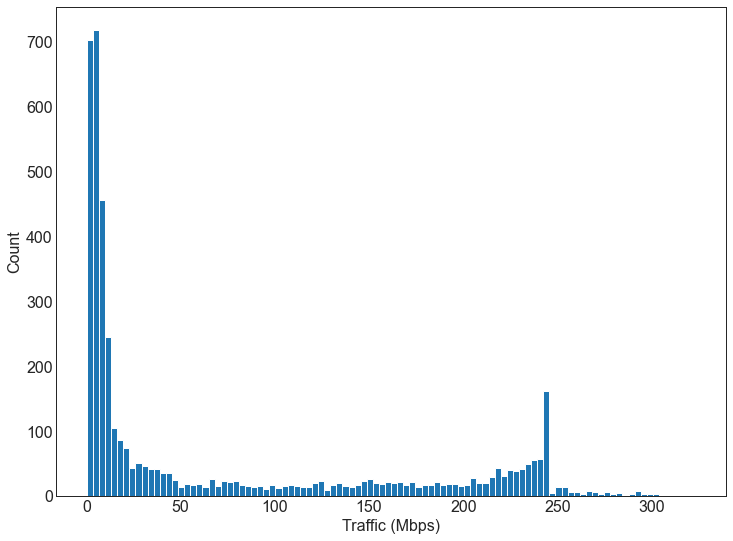

In [19]:
plt.figure(figsize=[12, 9])
plt.hist(df['value_avg'] / 1000 / 1000, bins=100)
plt.xlabel('Traffic (Mbps)')
plt.ylabel('Count')
plt.show()

Plot the min value distribution:

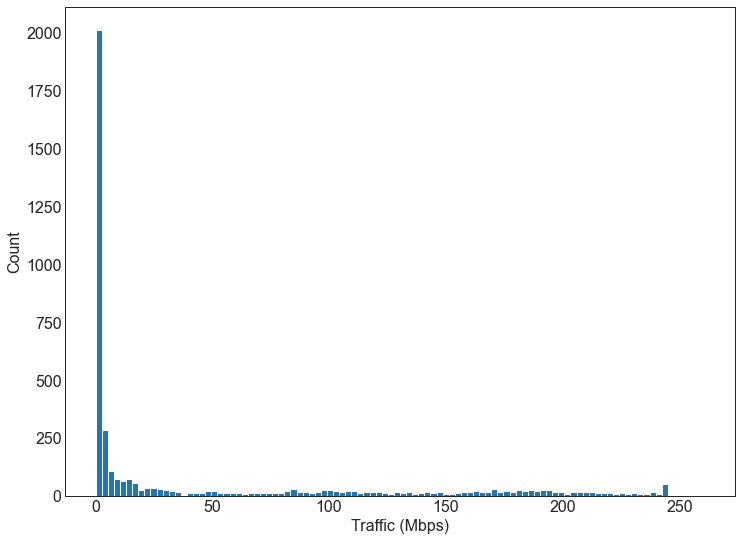

In [20]:
plt.figure(figsize=[12, 9])
plt.hist(df['value_min'] / 1000 / 1000, bins=100)
plt.xlabel('Traffic (Mbps)')
plt.ylabel('Count')
plt.show()

Plot the max value distribution:

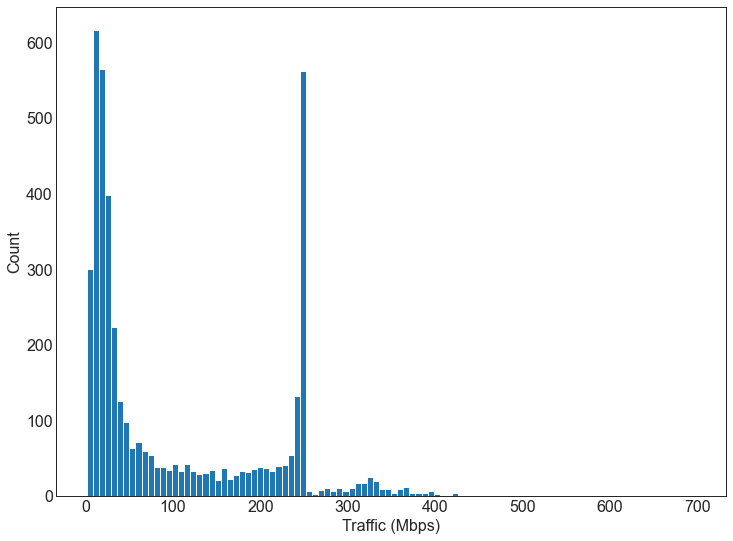

In [21]:
plt.figure(figsize=[12, 9])
plt.hist(df['value_max'] / 1000 / 1000, bins=100)
plt.xlabel('Traffic (Mbps)')
plt.ylabel('Count')
plt.show()

Let's plot the data in a time series style:

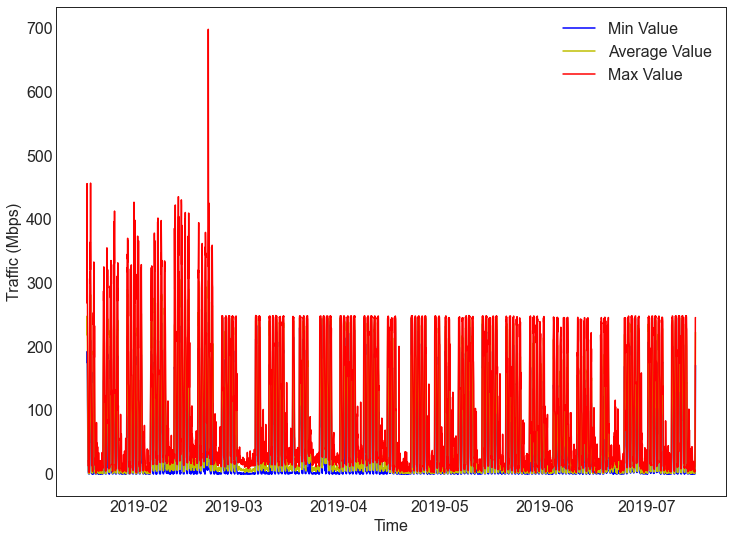

In [22]:
plt.figure(figsize=[12, 9])
plt.plot(df['datetime'], df['value_min'] / 1000 / 1000, 'b', label='Min Value')
plt.plot(df['datetime'], df['value_avg'] / 1000 / 1000, 'y', label='Average Value')
plt.plot(df['datetime'], df['value_max'] / 1000 / 1000, 'r', label='Max Value')
plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend()
plt.show()

It's hard to see the details. Let's plot three figures instead:

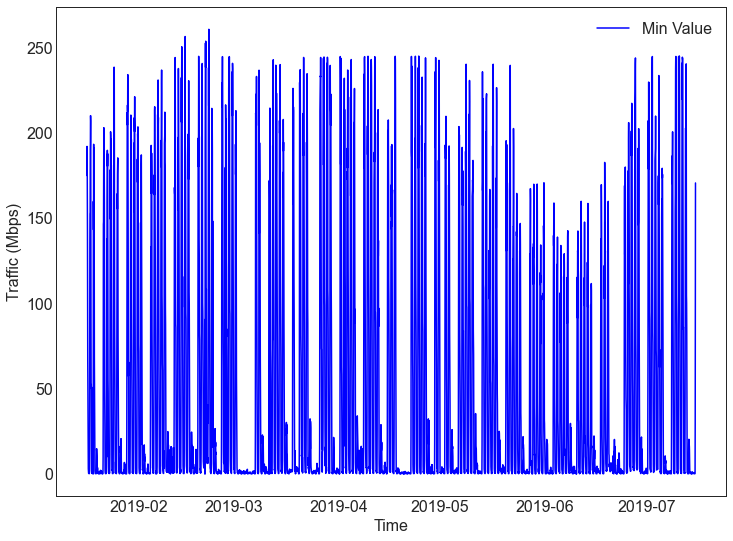

In [23]:
plt.figure(figsize=[12, 9])
plt.plot(df['datetime'], df['value_min'] / 1000 / 1000, 'b', label='Min Value')
# plt.plot(df['datetime'], df['value_avg'] / 1000 / 1000, 'y', label='Average Value')
# plt.plot(df['datetime'], df['value_max'] / 1000 / 1000, 'r', label='Max Value')
plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend()
plt.show()

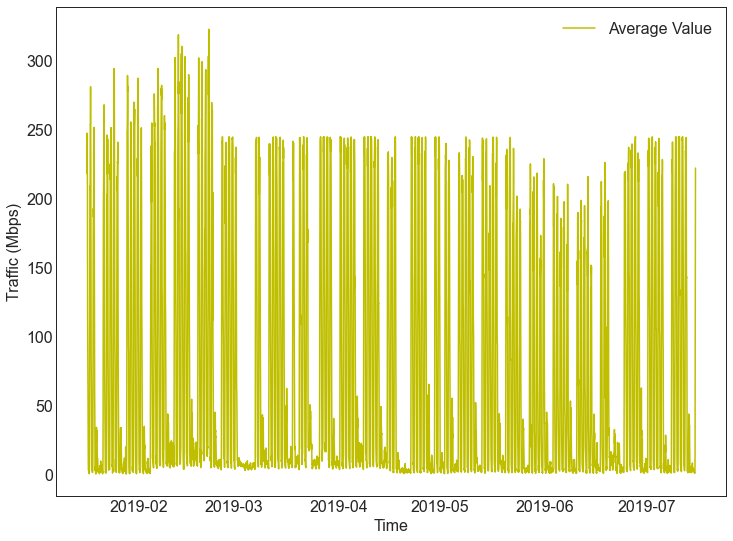

In [24]:
plt.figure(figsize=[12, 9])
# plt.plot(df['datetime'], df['value_min'] / 1000 / 1000, 'b', label='Min Value')
plt.plot(df['datetime'], df['value_avg'] / 1000 / 1000, 'y', label='Average Value')
# plt.plot(df['datetime'], df['value_max'] / 1000 / 1000, 'r', label='Max Value')
plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend()
plt.show()

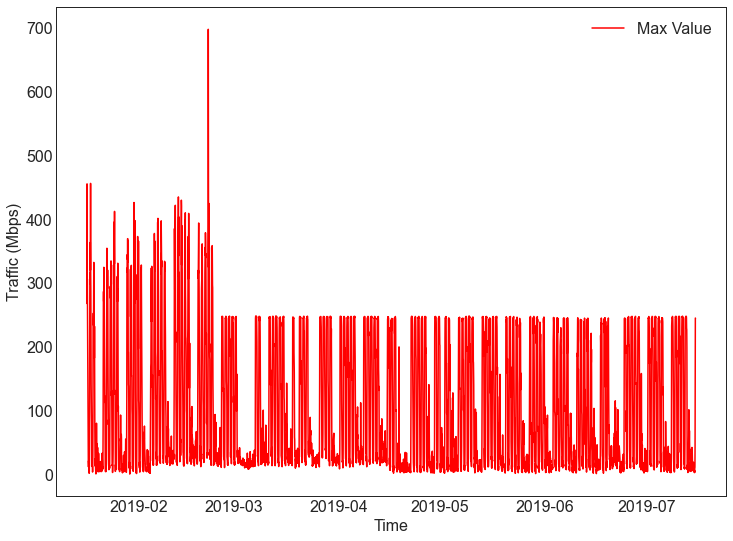

In [25]:
plt.figure(figsize=[12, 9])
# plt.plot(df['datetime'], df['value_min'] / 1000 / 1000, 'b', label='Min Value')
# plt.plot(df['datetime'], df['value_avg'] / 1000 / 1000, 'y', label='Average Value')
plt.plot(df['datetime'], df['value_max'] / 1000 / 1000, 'r', label='Max Value')
plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend()
plt.show()

The data is sampled in hours. We try to decompose the average data:

In [26]:
# add a datetimeindex
dates = pd.DatetimeIndex(df['datetime'])
df = df.set_index(dates).asfreq('H')  # one hour as the original sampling time frequency
df.shape

(4319, 7)

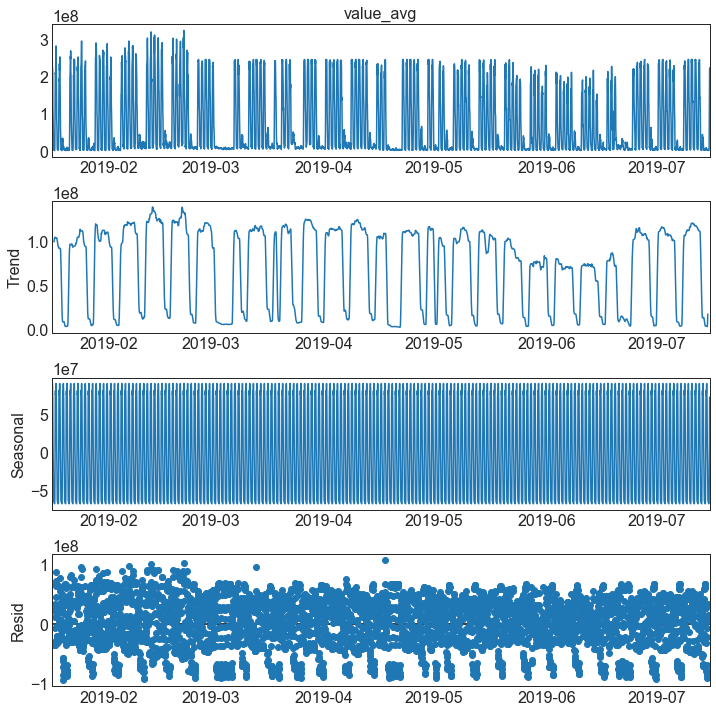

In [27]:
# Decompose 
result = seasonal_decompose(df['value_avg'], model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (10, 10)})
result.plot()
plt.show()

It is too hard to observe. That's draw a smaller time range:

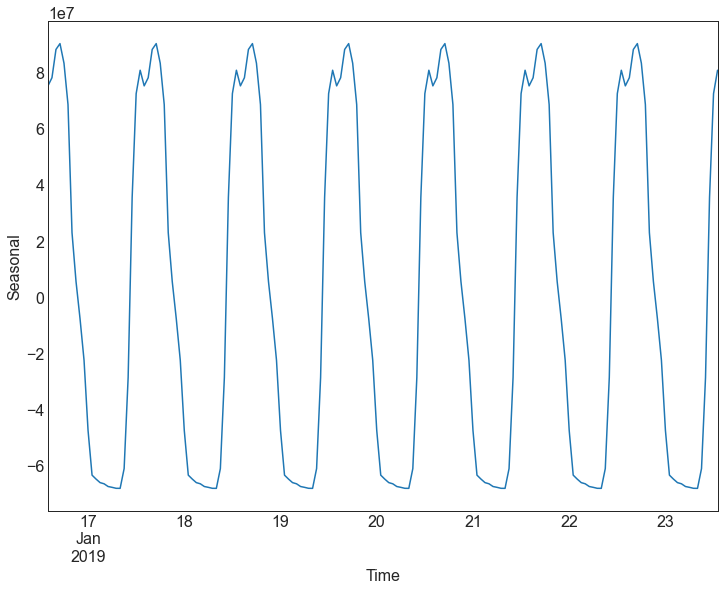

In [28]:
plt.figure(figsize=[12, 9])
result.seasonal.head(24 * 7).plot()  # 7 days * 24 hours
plt.xlabel('Time')
plt.ylabel('Seasonal')
plt.show()

This time, the seasonal part gives us a hint that the data show a daily pattern.

# Stationarity in a Univariate Time Series

For this part, we take the average value as our prediction target. It is a **univarite time series**.

A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, are relatively constant over time. Thus, a non-stationary series is one whose statistical properties change over time.

Before starting any predictive modeling it is necessary to verify if these statistical properties are constant:
* Constant mean
* Constant variance
* Auto correlated

A stationary series has a relatively constant mean over time, there are no bullish or bearish trends. The reason is that having a constant mean with small variations around it, makes much easier to extrapolate to the future. If the series is not stationary the forecast for the future will not be efficient.

In [29]:
data = df['value_avg'].values

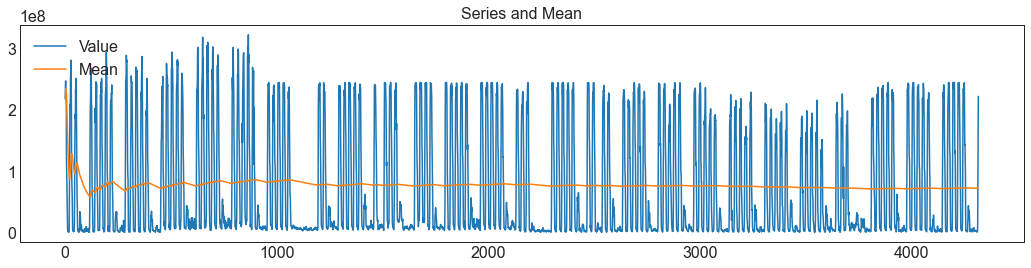

In [30]:
# Creating an average that expands from the first value and accumulate until each day
mean = [np.mean(data[:x]) for x in range(len(data))]
plt.figure(figsize=(18,4))
plt.plot(data, label='Value')
plt.plot(mean, label='Mean')
plt.title('Series and Mean')
plt.legend()
plt.show()

The mean value changes a lot at the beginning but it becomes stable gradually.

When two variables have similar variation in relation to the standard deviation during time you can say that these variables are correlated. 

When the subject is Autocorrelation, it means that there is a correlation of certain previous periods with the current period, the name given to the period with this correlation is **lag**, for example: in a series that has measurements every hour, today's temperature at 12:00 is very similar to the temperature of 24 hours ago and if you compare the variation of temperatures through the time between these 24 hours period there will be an auto correlation, in this case we will have an autocorrelation with the 24th lag.

Autocorrelation is a condition to create forecasts with a single variable, because if there is no correlation, you can not use past values to predict the future, when there are several variables, you can verify if there is a correlation between the dependent variable and the lags of the independent variables.

**If a series does not have autocorrelation, it is a series with random and unpredictable sequences and the best way to make a prediction is usually to use the value from the previous day or time period.**

Now we split the data into training and test subsets. We use five months as training set (for hyperparameter tuning, four months as training set, one month as validation set) and one month as test set.

In [31]:
train = df[df['datetime'] < '2019-06-16 00:00:00']
test = df[df['datetime'] > '2019-06-16 00:00:00']
train_length = train.shape[0]
test_length = test.shape[0]

In [32]:
print('Training size: ', train_length)
print('Test size: ', test_length)

Training size:  3610
Test size:  708


In [33]:
print('Test ratio: ', test_length / (test_length + train_length))

Test ratio:  0.16396479851783233


Now we plot the different time periods data:

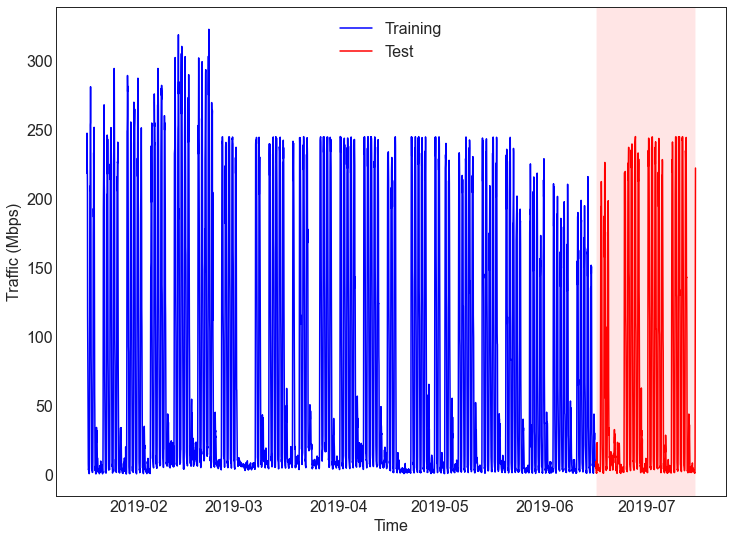

In [34]:
plt.figure(figsize=[12, 9])
plt.plot(df.index[:train_length], df['value_avg'][:train_length] / 1000 / 1000, label='Training', color='blue')
plt.plot(df.index[train_length:], df['value_avg'][train_length:] / 1000 / 1000, label='Test', color='red')
plt.axvspan(df.index[train_length:][0], df.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

From now on we will only use the training set to do the studies, the test set will only be used to validate the predictions that we will make.

It is indicated to use statistical tests to confirm if the series is stationary, we will use two tests: the **Dickey Fuller test** and the **KPSS test**.

First we will use the Dickey Fuller test, I will use the base P value of 5%, that is, if the P value is below these 5% it means that the series is statistically stationary.

In [35]:
# Dickey Fuller Test
adfinput = adfuller(train['value_avg'])
adftest = pd.Series(adfinput[0:4], index=['Dickey Fuller Statistical Test', 'P-value',
                                          'Used Lags', 'Number of comments used'])
adftest = round(adftest, 4)
    
for key, value in adfinput[4].items():
    adftest["Critical Value (%s)"%key] = value.round(4) 
adftest

Dickey Fuller Statistical Test      -6.8056
P-value                              0.0000
Used Lags                           30.0000
Number of comments used           3579.0000
Critical Value (1%)                 -3.4322
Critical Value (5%)                 -2.8623
Critical Value (10%)                -2.5672
dtype: float64

In this case the Dickey Fuller test indicated that **the series is stationary**. The value P is zero and if we compare, the value of the statistical test is far below the critical values.

Now we are going to analyze the series with the KPSS test, unlike the Dickey Fuller test, the KPSS test already assumes that the series is stationary and only will not be if the P value is less than 5% or the statistical test is greater than some value critic:

In [36]:
kpss_input = kpss(train['value_avg'])
kpss_test = pd.Series(kpss_input[0:3], index=['Statistical Test KPSS', 'P-Value', 'Used Lags'])
kpss_test = round(kpss_test,4)
    
for key, value in kpss_input[3].items():
    kpss_test["Critical Value (%s)"%key] = value 
kpss_test

D:\Anaconda\envs\pytorch\lib\site-packages\statsmodels\tsa\stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


Statistical Test KPSS     0.2789
P-Value                   0.1000
Used Lags                30.0000
Critical Value (10%)      0.3470
Critical Value (5%)       0.4630
Critical Value (2.5%)     0.5740
Critical Value (1%)       0.7390
dtype: float64

The KPSS test also shows that the series is stationary because P value is larger than 0.05 and the statistical test is below any critical value.

To be predictable a series with a single variable must have auto-correlation, that is, the current period must be explained based on an earlier period (a lag).

As this series has daily periods, 1 day is 24 hours.There could also be weekly patterns.

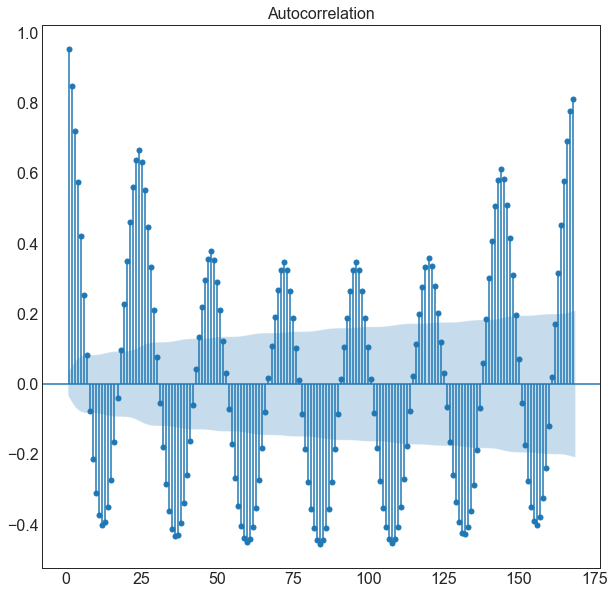

In [37]:
plot_acf(train['value_avg'], lags=24 * 7, zero=False);

The above figure shows that many lags could be used to create forecasts for future events, since they are outside of the confidence interval.

Another very important function is the partial autocorrelation function, where the effect of previous lags on the current period are removed and only the effect of the lag analyzed over the current period remains, for example: the partial autocorrelation of the fourth lag will remove the effects of the first, second and third lags.

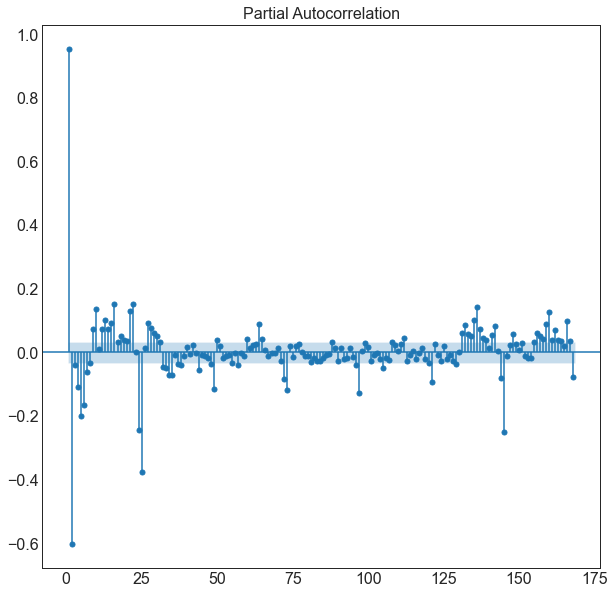

In [38]:
plot_pacf(train['value_avg'], lags=24 * 7, zero=False);

From the above figure, we try to use only the first two lags as a predictor for auto-regressive series.

# Univariate Time Series Prediction

We first define the evaluation metrics:

In [39]:
def check_error(orig, pred, name_col='', index_name=''):
    
    bias = np.mean(orig - pred)
    mse = mean_squared_error(orig, pred)
    rmse = sqrt(mean_squared_error(orig, pred))
    mae = mean_absolute_error(orig, pred)
    mape = np.mean(np.abs((orig - pred) / orig)) * 100
    
    error_group = [bias, mse, rmse, mae, mape]
    result = pd.DataFrame(error_group, index=['BIAS','MSE','RMSE','MAE', 'MAPE'], columns=[name_col])
    result.index.name = index_name
    
    return result

We would also analyze the characteristics of the residual itself, as there are cases where the model can not capture the information necessary to make a good forecast resulting in a error with information that should be used to improve the forecast.

To verify this residual we will check:

* Actual vs. predicted values (sequential chart);

* Residual vs. predicted values (dispersion chart):
    + It is very important to analyze this graph, since in it we can check patterns that can tell us if some modification is needed in the model, the ideal is that the error is distributed linearly along the forecast sequence.

* QQ plot of the residual (dispersion chart):
    + Summarizing this is a graph that shows where the residue should be theoretically distributed, following a Gaussian distribution, versus how it actually is.

* Residual autocorrelation (sequential chart):
    + Where there should be no values that come out of the confidence margin, or the model is leaving information out of the model.

In [40]:
def plot_error(data, figsize=(12, 9), lags=24, rotation=0):
    
    # Creating the column error
    data['Error'] = data.iloc[:,0] - data.iloc[:,1]
    
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    # Plotting actual and predicted values
    ax1.plot(data.iloc[:, 0:2])
    ax1.legend(['Real', 'Pred'])
    ax1.set_title('Real Value vs Prediction')
    ax1.xaxis.set_tick_params(rotation=rotation)
    
    # Error vs Predicted value
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residual')
    ax2.set_title('Residual vs Predicted Values')
    
    # Residual QQ Plot
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation Plot of residual
    plot_acf(data.iloc[:, 2], lags=lags, zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

Now we set the column to predict:

In [41]:
target = 'value_avg'

# Simple Approach

Now we use the last values as the predictions. This is often used as a baseline. Sometimes it could be the best method as we discussed earlier.

In [42]:
#C reating the training variable to compare with the error later
simple_train = train[[target]]
simple_train.columns = ['Real']
simple_train['Pred'] = simple_train['Real'].shift()
simple_train.dropna(inplace=True)

In [43]:
simple_train.head()

,Real,Pred
datetime,,
2019-01-16 15:00:00,239018429,218584709.0
2019-01-16 16:00:00,247729961,239018429.0
2019-01-16 17:00:00,222326142,247729961.0
2019-01-16 18:00:00,220546435,222326142.0
2019-01-16 19:00:00,205955438,220546435.0


Let's create a variable to check the training error of this model, we will also plot the graphs mentioned above:

SIMPLE MODEL IN THE TRAINING DATA


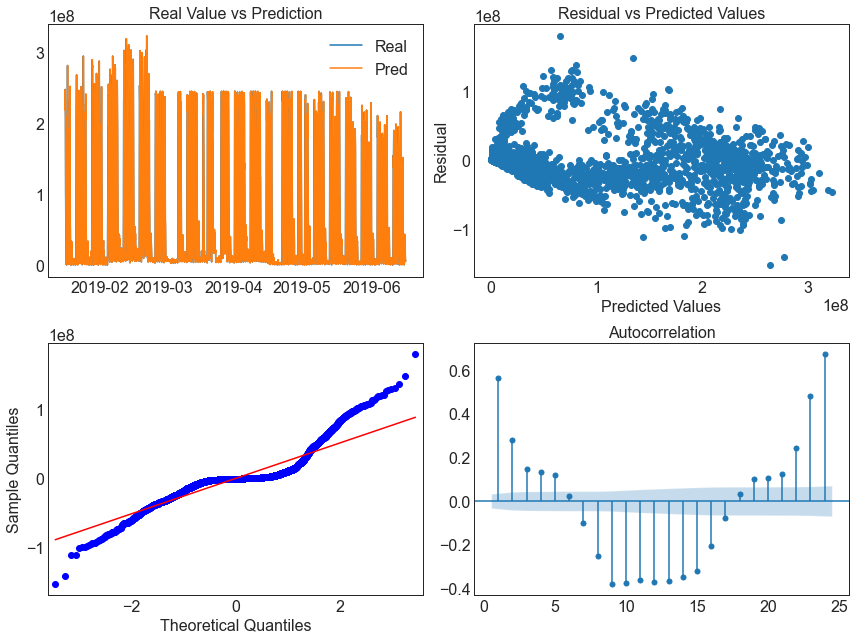

,Simple
Training Base,
BIAS,-5.866410e+04
MSE,7.942307e+14
RMSE,2.818210e+07
MAE,1.569445e+07
MAPE,4.394432e+01


In [44]:
error_train = check_error(simple_train['Real'], 
                         simple_train['Pred'], 
                         name_col='Simple', 
                         index_name='Training Base')

print('SIMPLE MODEL IN THE TRAINING DATA')
plot_error(simple_train)
error_train

The QQ graph shows that there are some larger (up and down) residuals than theoretically should be, these are the so-called outliers, and there is still a significant autocorrelation in many lags, which could be used to improve the model.

In the same way we will now make the forecast in the test data. The first value of the predicted series will be the last of the training data, then these values will be updated step-by-step by the current value of the test and so on:

SIMPLE MODEL IN THE TEST DATA


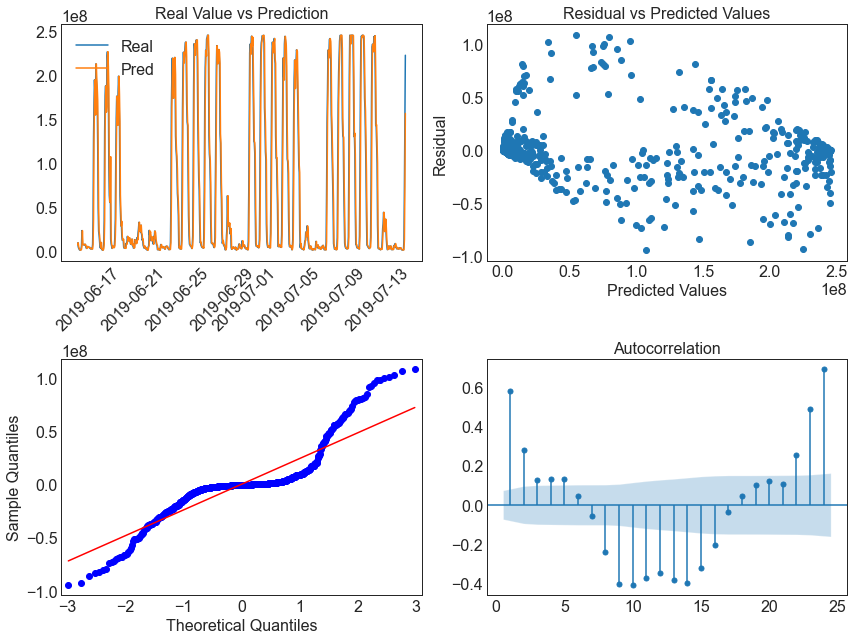

,Simple
Testing Base,
BIAS,3.044920e+05
MSE,7.135330e+14
RMSE,2.671204e+07
MAE,1.450096e+07
MAPE,5.046137e+01


In [45]:
simple_test = test[[target]]
simple_test.columns = ['Real']

#adding the first value of the Forecast with the last Actual data of the test
hist = [simple_train.iloc[i, 0] for i in range(len(simple_train))]

pred = []
for t in range(len(simple_test)):
    yhat = hist[-1]
    obs = simple_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)

simple_test['Pred'] = pred

#creating the basis of error in the test
error_test = check_error(simple_test['Real'], 
                        simple_test['Pred'], 
                        name_col='Simple',
                       index_name='Testing Base')

print('SIMPLE MODEL IN THE TEST DATA')
plot_error(simple_test, rotation=45)
error_test

# Simple Moving Average

The moving average is an average that is calculated for a given period (5 hours for example) and is moving and always being calculated using this particular period.

In [46]:
sma_train = train[[target]]
sma_train.columns = ['Real']
sma_train['Pred'] = sma_train.rolling(5).mean()
sma_train.dropna(inplace=True)

# Checking the error of the moving averages on the training model
error_train['5H Moving Avg'] = check_error(sma_train['Real'], sma_train['Pred'])
error_train

,Simple,5H Moving Avg
Training Base,,
BIAS,-5.866410e+04,-1.254449e+05
MSE,7.942307e+14,1.903467e+15
RMSE,2.818210e+07,4.362874e+07
MAE,1.569445e+07,2.691271e+07
MAPE,4.394432e+01,9.775340e+01


The error is above the simple model.

5-Hour MOVING AVERAGE MODEL ON THE TEST DATA


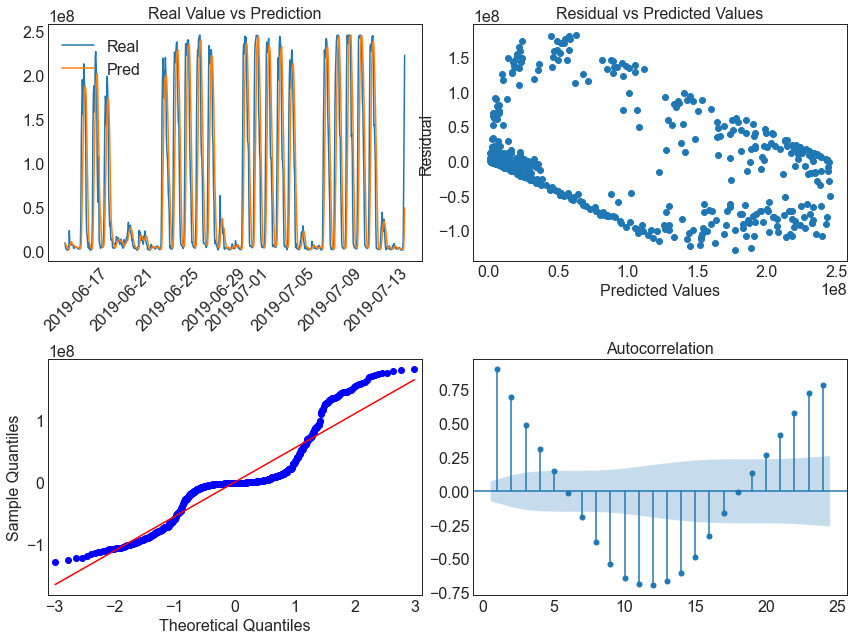

,Simple,5H Moving Avg
Testing Base,,
BIAS,3.044920e+05,5.302848e+05
MSE,7.135330e+14,3.418481e+15
RMSE,2.671204e+07,5.846778e+07
MAE,1.450096e+07,3.638138e+07
MAPE,5.046137e+01,1.759863e+02


In [47]:
sma_test = test[[target]]
sma_test.columns = ['Real']

# Continuing to use the 5-hour moving average step by step:
hist = [sma_train.iloc[i,0] for i in range(len(sma_train))]
pred = []
for t in range(len(sma_test)):
    yhat = np.mean(hist[-5:])
    obs = sma_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)
    
sma_test['Pred'] = pred

# plotting the test chart
print('5-Hour MOVING AVERAGE MODEL ON THE TEST DATA')
plot_error(sma_test, rotation=45)

# Checking the error of the moving average on test model
error_test['5H Moving Avg'] = check_error(sma_test['Real'], sma_test['Pred'])
error_test

The test error is also above the simple model.

# Exponential Moving Average

$\alpha$(alpha) is a constant with a value between 0 and 1, we will calculate the forecast with the following formula:

$$Ypred_t=Ypred_{t−1}+\alpha(Y_{t−1}−Ypred_{t−1})$$

We try different alpha values:

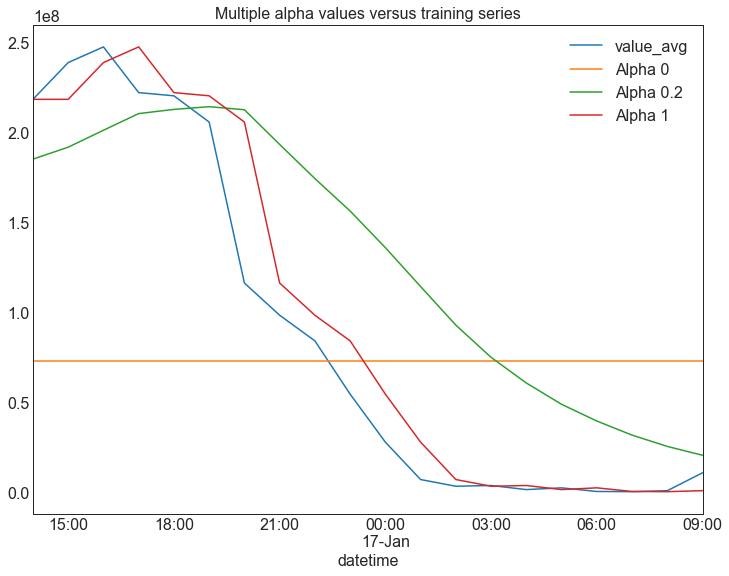

In [48]:
emm = train[[target]]
alpha_ = [0, 0.2, 1]
for key, value in enumerate(alpha_):
    model = ExponentialSmoothing(emm[target]).fit(smoothing_level= value)
    emm[f'Alpha {value}'] = model.predict(start=0, end=len(emm)-1)

# plotting part of the graph to improve visualization
emm[:20].plot(figsize=(12, 9), title='Multiple alpha values versus training series')
plt.show()

The average data period in the EMM forecast is $1/\alpha$ . For example, when $\alpha= 0.5$, lag is equivalent to 2 periods; when $\alpha= 0.2$ the lag is 5 periods; when $\alpha= 0.1$ the lag is 10 periods and so on.

Here we would use $\alpha= 0.2$ as the baseline:

In [49]:
emm_train = train[[target]]
emm_train.columns = ['Real']

# Creating the model:
alpha = 0.2
model = ExponentialSmoothing(emm_train['Real']).fit(smoothing_level= alpha)
emm_train['Pred'] = model.predict(start=0, end=len(emm_train)-1)

# Checking the error of the exponential moving averages training model
error_train['Exp. Moving Avg'] = check_error(emm_train['Real'], emm_train['Pred'])
error_train

,Simple,5H Moving Avg,Exp. Moving Avg
Training Base,,,
BIAS,-5.866410e+04,-1.254449e+05,-2.381341e+05
MSE,7.942307e+14,1.903467e+15,4.644447e+15
RMSE,2.818210e+07,4.362874e+07,6.815018e+07
MAE,1.569445e+07,2.691271e+07,5.017590e+07
MAPE,4.394432e+01,9.775340e+01,3.810705e+02


The error is better than the simple moving average, but still above the simple method.

EXPONENTIAL MOVING AVERAGE WITH 0.50 ALPHA ON THE TEST DATA


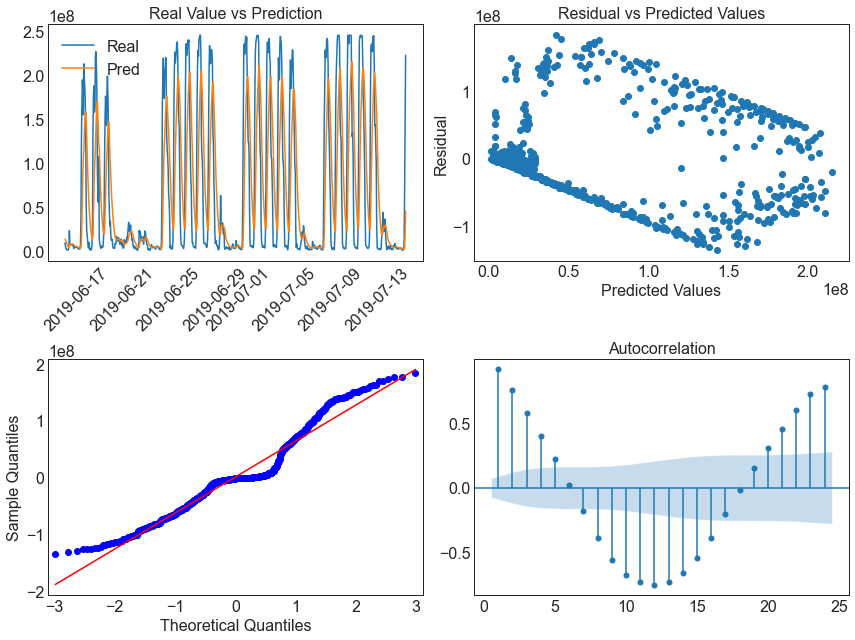

,Simple,5H Moving Avg,Exp. Moving Avg
Testing Base,,,
BIAS,3.044920e+05,5.302848e+05,4.767857e+05
MSE,7.135330e+14,3.418481e+15,4.169927e+15
RMSE,2.671204e+07,5.846778e+07,6.457497e+07
MAE,1.450096e+07,3.638138e+07,4.612858e+07
MAPE,5.046137e+01,1.759863e+02,3.743846e+02


In [50]:
emm_test = test[[target]]
emm_test.columns = ['Real']

#creating the model
hist = [emm_train.iloc[i,0] for i in range(len(emm_train))]
hist_pred = [emm_train.iloc[i,1] for i in range(len(emm_train))]
pred = []
for t in range(len(emm_test)):
    yhat = hist_pred[-1] + alpha * (hist[-1] - hist_pred[-1])
    obs = emm_test.iloc[t,0]
    pred.append(yhat)
    hist.append(obs)
    hist_pred.append(yhat)

emm_test['Pred'] = pred

# plotting the test chart
print('EXPONENTIAL MOVING AVERAGE WITH 0.50 ALPHA ON THE TEST DATA')
plot_error(emm_test, rotation=45)

# Checking the error of the exponential moving averages test model
error_test['Exp. Moving Avg'] = check_error(emm_test['Real'], emm_test['Pred'])
error_test

# Auto Regressive

An auto-regressive model is basically a linear regression with significantly correlated lags, where the autocorrelation and partial autocorrelation charts should initially be plotted to verify if there is anything relevant.

In [52]:
ar_train = train[[target]]
ar_train.columns = ['Real']

# Creating the model:
# use 2 lags
model = ARMA(ar_train['Real'], order=[2, 0]).fit()
ar_train['Pred'] = model.predict(start=0, end=len(ar_train)-1)


def f_zero(x):
    if x > 0:
        return x
    else:
        return 0

ar_train['Pred'] = ar_train['Pred'].apply(f_zero)

# Checking the auto regressive model error
error_train['Auto Regr.'] = check_error(ar_train['Real'], ar_train['Pred'])
error_train

,Simple,5H Moving Avg,Exp. Moving Avg,Auto Regr.
Training Base,,,,
BIAS,-5.866410e+04,-1.254449e+05,-2.381341e+05,-8.282053e+04
MSE,7.942307e+14,1.903467e+15,4.644447e+15,4.971936e+14
RMSE,2.818210e+07,4.362874e+07,6.815018e+07,2.229784e+07
MAE,1.569445e+07,2.691271e+07,5.017590e+07,1.400577e+07
MAPE,4.394432e+01,9.775340e+01,3.810705e+02,9.320277e+01


Finally we are better than the simple method.

AUTO REGRESSIVE MODEL IN THE TEST DATA


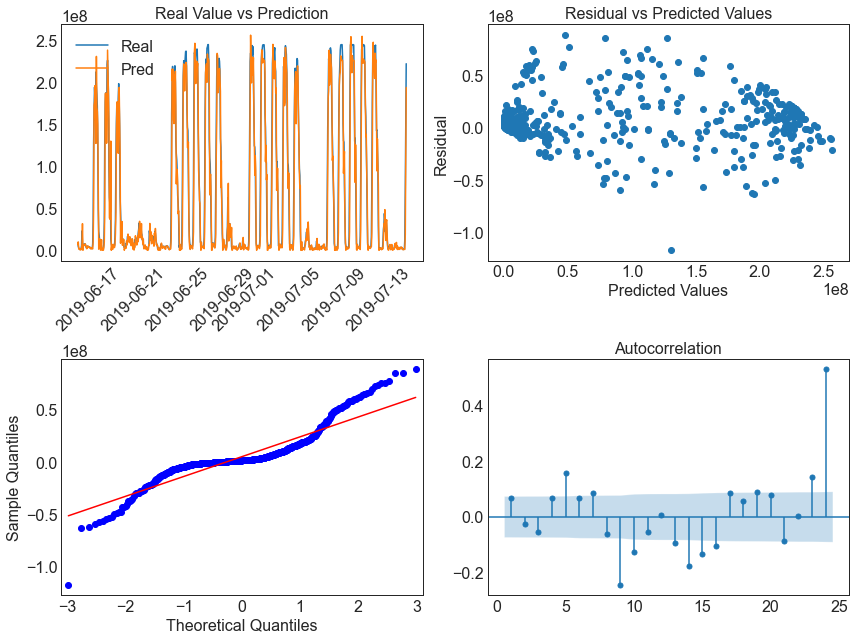

,Simple,5H Moving Avg,Exp. Moving Avg,Auto Regr.
Testing Base,,,,
BIAS,3.044920e+05,5.302848e+05,4.767857e+05,4.967748e+06
MSE,7.135330e+14,3.418481e+15,4.169927e+15,4.455746e+14
RMSE,2.671204e+07,5.846778e+07,6.457497e+07,2.110864e+07
MAE,1.450096e+07,3.638138e+07,4.612858e+07,1.218367e+07
MAPE,5.046137e+01,1.759863e+02,3.743846e+02,4.650657e+01


In [53]:
ar_test = test[[target]]
ar_test.columns = ['Real']

# validating the data using the coefficients of the trained model
coef_l1, coef_l2 = model.arparams
hist = [ar_train.iloc[i,0] for i in range(len(ar_train))]
pred = []
for t in range(len(ar_test)):
    yhat = (hist[-1] * coef_l1) + (hist[-2] * coef_l2)
    obs = ar_test.iloc[t, 0]
    pred.append(yhat)
    hist.append(obs)
    
ar_test['Pred'] = pred

ar_test['Pred'] = ar_test['Pred'].apply(f_zero)

# plotting the test chart
print('AUTO REGRESSIVE MODEL IN THE TEST DATA')
plot_error(ar_test, rotation=45)

# Checking the auto regressive model error
error_test['Auto Regr.'] = check_error(ar_test['Real'], ar_test['Pred'])
error_test

The test error is also better than the simple method.

# Prediction as a Multivariate Time Series

We would try to use the min, max, average values to predict the average value

In [54]:
input_features = ['value_avg', 'value_min', 'value_max']
target = 'value_avg'

# Testing Causation using Granger’s Causality Test

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system. Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.
In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [55]:
maxlag = 24
_test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, _test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][_test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(train, variables = input_features)

,value_avg_x,value_min_x,value_max_x
value_avg_y,1.0,0.0,0.0
value_min_y,0.0,1.0,0.0
value_max_y,0.0,0.0,1.0


The row are the Response (Y) and the columns are the predictor series (X). If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

For example, P-Value of 0.0 at (row 1, column 2) represents the p-value of the Grangers Causality test for value_min_x causing value_avg_y, which is less that the significance level of 0.05. So, you can reject the null hypothesis and conclude value_min_x causes value_avg_y.

Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

# Cointegration Test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

In [56]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(train[input_features])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
value_avg ::  1449.92   > 24.2761   =>   True
value_min ::  604.33    > 12.3212   =>   True
value_max ::  121.46    > 4.1296    =>   True


Then we would use all three time series as inputs.

# Vector Autoregressions (VAR)

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

we implement a nice function (adfuller_test()) that writes out the results of the ADF test for any given time series and implement this function on each series one-by-one.

In [57]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

Call the adfuller_test() on each series.

In [58]:
# ADF Test on each column
for name, column in train[input_features].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "value_avg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8056
 No. Lags Chosen       = 30
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "value_min" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9413
 No. Lags Chosen       = 30
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "value_max" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

All three time series are stationary.

In [59]:
data = train[input_features]

model = VAR(data)

To choose the order(p) of the VAR models is to use the model.select_order(maxlags) method.

The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.

In [60]:
# we can further select the lag
results = model.select_order(maxlags=15)
results.summary()

,AIC,BIC,FPE,HQIC
0,103.6,103.6,9.551e+44,103.6
1,100.8,100.8,5.819e+43,100.8
2,100.3,100.3,3.562e+43,100.3
3,100.3,100.3,3.505e+43,100.3
4,100.3,100.3,3.453e+43,100.3
5,100.2,100.3,3.254e+43,100.2
6,100.1,100.2,3.081e+43,100.2
7,100.1,100.2,3.050e+43,100.2
8,100.1,100.2,2.997e+43,100.2
9,100.1,100.2,2.827e+43,100.1


Based on the above result, we choose 15 as the optimal lag.

In [61]:
model_fitted = model.fit(24)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Jul, 2021
Time:                     10:00:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    100.037
Nobs:                     3586.00    HQIC:                   99.7938
Log likelihood:          -193735.    FPE:                1.91173e+43
AIC:                      99.6591    Det(Omega_mle):     1.79957e+43
--------------------------------------------------------------------
Results for equation value_avg
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const           3459154.305851    776447.421218            4.455           0.000
L1.value_avg          1.047085         0.036076           29.025           0.000
L1.value_min          0.025222         0.026240         

Get the lag order:

In [62]:
lag_order = model_fitted.k_ar
lag_order

24

In [63]:
var_train = train[[target]]
var_train.columns = ['Real']

input_data = train[input_features].values
# We only predict all time series
# But use only the target column
predicted_values = []
for i in range(input_data.shape[0]):
    if i < lag_order:
        # No prediction for the first lag_order samples
        predicted_values.append(np.nan)
    else:
        input_batch = input_data[i-lag_order:i]
        result = model_fitted.forecast(y=input_batch, steps=1)
        predicted_values.append(result[0][0])

var_train['Pred'] = predicted_values
var_train = var_train.dropna()

var_train['Pred'] = var_train['Pred'].apply(f_zero)

In [64]:
# Checking the error
error_train['VAR'] = check_error(var_train['Real'], var_train['Pred'])
error_train

,Simple,5H Moving Avg,Exp. Moving Avg,Auto Regr.,VAR
Training Base,,,,,
BIAS,-5.866410e+04,-1.254449e+05,-2.381341e+05,-8.282053e+04,-3.289610e+05
MSE,7.942307e+14,1.903467e+15,4.644447e+15,4.971936e+14,3.210017e+14
RMSE,2.818210e+07,4.362874e+07,6.815018e+07,2.229784e+07,1.791652e+07
MAE,1.569445e+07,2.691271e+07,5.017590e+07,1.400577e+07,1.142028e+07
MAPE,4.394432e+01,9.775340e+01,3.810705e+02,9.320277e+01,7.923045e+01


Now we evaluate on the test set:

In [65]:
var_test = test[[target]]
var_test.columns = ['Real']

train_data = train[input_features].values
test_data = test[input_features].values

hist = train_data
pred = []
for t in range(len(var_test)):
    input_batch = hist[-lag_order:]
    result = model_fitted.forecast(y=input_batch, steps=1)
    yhat = result[0][0]
    obs = test_data[t]
    pred.append(yhat)
    hist = np.vstack([hist, obs])
    
var_test['Pred'] = pred
var_test['Pred'] = var_test['Pred'].apply(f_zero)

VAR MODEL IN THE TEST DATA


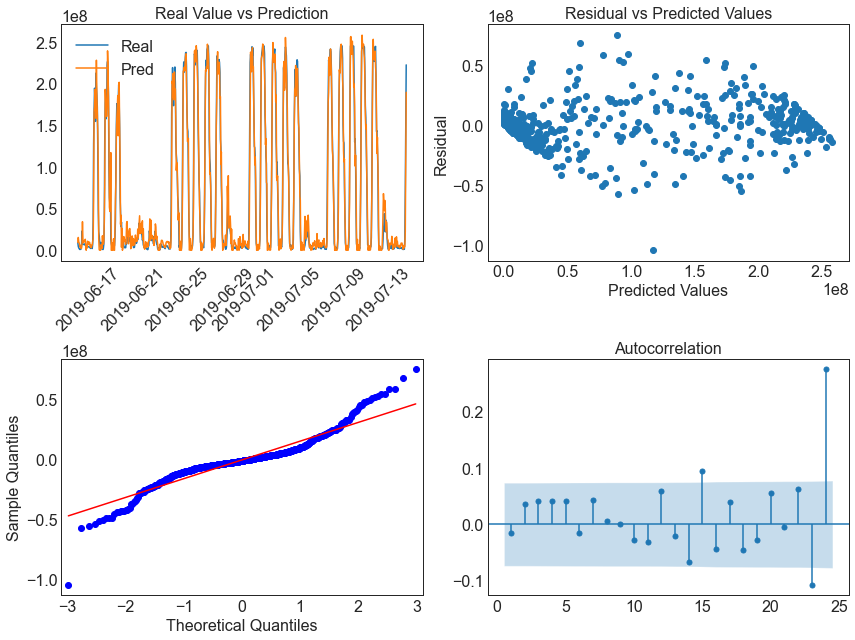

,Simple,5H Moving Avg,Exp. Moving Avg,Auto Regr.,VAR
Testing Base,,,,,
BIAS,3.044920e+05,5.302848e+05,4.767857e+05,4.967748e+06,-5.128593e+05
MSE,7.135330e+14,3.418481e+15,4.169927e+15,4.455746e+14,2.681724e+14
RMSE,2.671204e+07,5.846778e+07,6.457497e+07,2.110864e+07,1.637597e+07
MAE,1.450096e+07,3.638138e+07,4.612858e+07,1.218367e+07,1.050558e+07
MAPE,5.046137e+01,1.759863e+02,3.743846e+02,4.650657e+01,9.025847e+01


In [66]:
# plotting the test chart
print('VAR MODEL IN THE TEST DATA')
plot_error(var_test, rotation=45)

# Checking the VAR model error
error_test['VAR'] = check_error(var_test['Real'], var_test['Pred'])
error_test

The results become better.

Save the predicted results of VAR:

In [68]:
model_name = 'VAR'
history = 24
horizon = 1
y_pred_fn = '%s_pred-%d-%d.pkl' % (model_name, history, horizon)
import pickle
pred = np.array(var_test['Pred'])
pickle.dump(pred, open(y_pred_fn, 'wb'))